# Modelling developmental trajectories of white matter in newborns 



In [1]:
# Setup 

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/saad/python-modules')
from mh import MH, plot_samples, gauss_logpr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, glob
import scipy as sp
sns.set()
sns.set_context('talk')


In [128]:
# Read in design matrix
df = pd.read_csv('/Users/saad/Desktop/tmp_matteo/input_vars/input_vars_design_mat.csv')
df['csf_vol'] = df['csf_vol']+df['ven_vol']  # define CSF = Ventricles+CorticalCSF


# Read in the tracts volumes

tracts_dir = '/Users/saad/Desktop/tmp_matteo/input_vars'
tracts_files = sorted(glob.glob(os.path.join(tracts_dir,'*_resorted.txt')))

tracts_names = []
tracts_vols  = []
exclude      = ['mcp','ml_l','ml_r']
indluce_mask = []
for i in range(len(tracts_files)):
    tract = os.path.splitext(os.path.split(tracts_files[i])[-1])[-2].split("_", 2)
    if tract[1] in ['l','r']:
        tract = tract[0]+"_"+tract[1]        
    else:
        tract = tract[0]
    if tract not in exclude:
        tracts_names.append(tract)
        tracts_vols.append(np.loadtxt(tracts_files[i])[:,1])
        indluce_mask.append(True)
    else:
        indluce_mask.append(False)

tracts_vols = np.asarray(tracts_vols).T
num_tracts  = tracts_vols.shape[1]

len(tracts_names)


26

----------------------------------
### Modelling code here
----------------------------------

In [17]:
# Prepare data
def prepare(df,name=None,Y=None,deconfound=False,normalise=True):
    # Data and regressors
    if name is not None:
        Y = np.array(df[name])
    b = np.array(df['age_birth'])
    s = np.array(df['age_scan'])
    if deconfound:
        # Confounds
        #df['brain_vol'] = np.array(df['gm_vol'])+np.array(df['wm_vol'])+np.array(df['ven_vol'])
        conf = np.array(df[['qc_snr','qc_cnr400','qc_cnr1000','qc_cnr2600']])
        # Regress out confounds from data
        from sklearn.linear_model import LinearRegression
        reg = LinearRegression(fit_intercept=True, normalize=False).fit(conf, Y)
        Y = Y - reg.predict(conf) + reg.intercept_    
    if normalise:
        # Normalise to 95th percentile
        Y = Y/np.quantile(Y,.95,axis=0)*100  

    return Y,b,s
             
   
# Various forward models
prem_thresh = 37 # prematurity threshold
# Only one slope (beta1=beta2)
def forward_0(p,s,b):
    return p[0]*s-p[0]*p[1]

# Same post-birth slopes for term and prem
def forward_1(p,s,b):
    pred = p[0]*b + p[1]*(s-b)- p[0]*p[2]    
    return pred
# Post-birth slope is different
def forward_2(p,s,b):
    term = b>=prem_thresh
    prem = b<prem_thresh
    
    pred = p[0]*b - p[0]*p[3]
    pred[term] += p[1]*(s[term]-b[term])
    pred[prem] += p[2]*(s[prem]-b[prem])
    return pred
# All slopes different - same onset
def forward_3(p,s,b):
    term = b>=prem_thresh
    prem = b<prem_thresh
    
    pred = np.zeros(s.size)
    pred[term] = p[0]*b[term] + p[1]*(s[term]-b[term])- p[0]*p[4]
    pred[prem] = p[2]*b[prem] + p[3]*(s[prem]-b[prem])- p[2]*p[4]
    
    return pred


class ForwardModel:
    def __init__(self,modelid):
        self.modelid = modelid
        if modelid == 0:
            self.forward = forward_0
            self.nparams = 2
            self.labels = ['beta1','onset']
        elif modelid == 1:
            self.forward = forward_1
            self.nparams = 3
            self.labels = ['beta1','beta2','onset']
        elif modelid == 2:
            self.forward = forward_2
            self.nparams = 4
            self.labels = ['beta1','beta2-term','beta2-prem','onset']
        elif modelid == 3:
            self.forward = forward_3
            self.nparams = 5
            self.labels = ['beta1-term','beta2-term','beta1-prem','beta2-prem','onset']
        else:
            raise Exception('Unknown model id.')
    def bounds(self):        
        if self.modelid == 0:
            LB = np.array([-np.inf,0])
            UB = np.array([ np.inf,40])
            return LB,UB
        elif self.modelid == 1:
            LB = np.array([-np.inf,-np.inf,0])
            UB = np.array([ np.inf, np.inf,40])
            return LB,UB
        elif self.modelid == 2:
            LB = np.array([-np.inf,-np.inf,-np.inf,0])
            UB = np.array([ np.inf, np.inf,np.inf,40])
            return LB,UB
        elif self.modelid == 3:
            LB = np.array([-np.inf,-np.inf,-np.inf,-np.inf,0])
            UB = np.array([ np.inf, np.inf, np.inf, np.inf,40])
            return LB,UB
        else:
            raise Exception('Unknown model id.')
    def init(self):       
        if self.modelid == 0:
            return np.array([0,0.00001])
        elif self.modelid == 1:
            return np.array([0,0,0.00001])
        elif self.modelid == 2:
            return np.array([0,0,0,0.00001])
        elif self.modelid == 3:
            return np.array([0,0,0,0,0.00001])
        else:
            raise Exception('Unknown model id.')
        
        
# Fit model to data
def do_fit(Y,b,s,forward_model):
    loglik  = lambda p : np.log(np.linalg.norm(Y-forward_model.forward(p,s,b)))*Y.size/2
    logpr   = lambda p : np.sum(gauss_logpr(p[:-1],loc=0,scale=40))
    # Bounds
    LB,UB = forward_model.bounds()
    # Initialise
    p0   = forward_model.init()

    mh = MH(loglik,logpr,njumps=10000)
    import time
    start = time.time()
    samples = mh.fit(p0,LB=LB,UB=UB)
    ML      = mh.marglik_Laplace(samples)
    
    return samples, ML

# SVD the data prior to fitting (for vertex-wise data)
def do_pca_fit(Y,b,s,forward_model,keep=10):
    
    if Y.shape[0]>Y.shape[1]:
        raise Exception("Data must be transposed")
    import scipy as sp
    #U,S,V = sp.sparse.linalg.svds(Y-Y.mean(axis=0),k=keep)
    U,S,V = sp.sparse.linalg.svds(Y,k=keep)
    
    all_betas = np.zeros((fm.nparams,keep))
    for i in range(keep):
        samples, _ = do_fit(Y@V[i,:].T,b,s,forward_model)
        betas = samples[:,:-1].mean(axis=0)
        betas = np.append(betas,-samples[:,-1].mean(axis=0)*betas[0])
        all_betas[:,i] = betas
    all_betas = all_betas@V
    grot1 = all_betas[:-1,:]
    grot2 = -all_betas[-1,:]/all_betas[0,:]
    all_betas = np.concatenate((grot1,grot2[None,:]))
    return all_betas


-------
### End of model code
-------

#### Quick fit 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


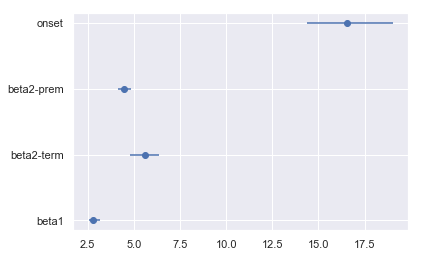

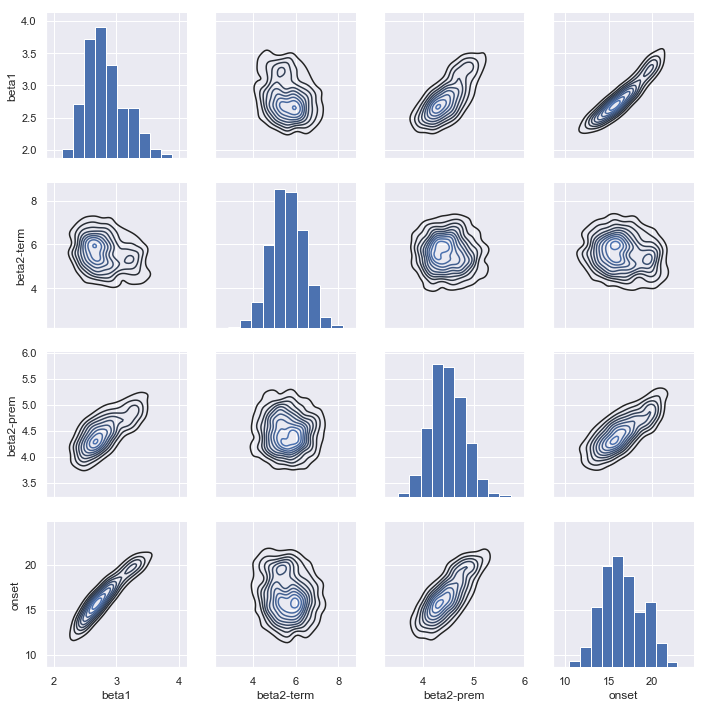

In [18]:
# Quick fit a model and look at the resuts
model = 2
fm    = ForwardModel(model)
name  = 'csf_vol'
data,birth,scan = prepare(df,name=name)
samples, ML = do_fit(data,birth,scan,fm)

plot_samples(samples,labels=fm.labels,plot_type='vector')
plot_samples(samples,labels=fm.labels,plot_type='matrix')


### ANALYSIS 1: Gross volumetric changes

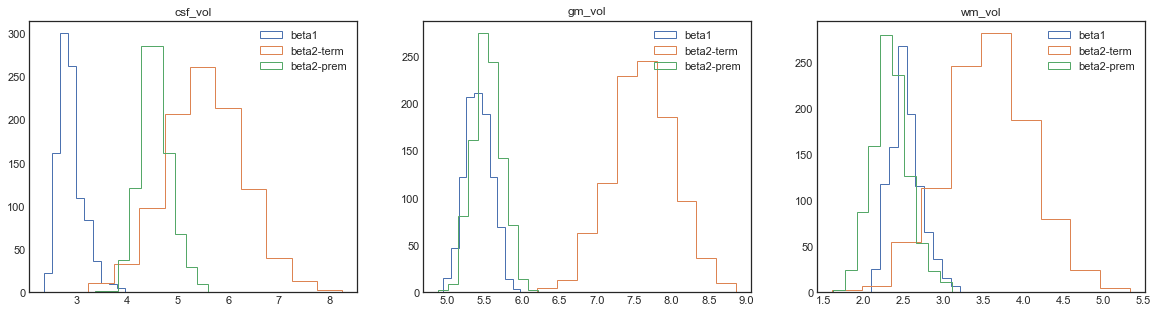

In [19]:

# COMPARE CSF,GM,WM 

fm = ForwardModel(2)
param_list = [0,1,2]

plt.style.use('seaborn-white')
plt.figure(figsize=(20,5))
for idx,name in enumerate(['csf_vol','gm_vol','wm_vol']):
    Y,b,s = prepare(df,name)
    samples,_ = do_fit(Y,b,s,fm)    
    
    plt.subplot(1, 3, idx+1)
    [plt.hist(samples[:,i],histtype='step') for i in param_list]
    plt.legend([ fm.labels[i] for i in param_list ])
    plt.title(name)



In [20]:
# BAYESIAN MODEL COMPARISON
# WITH APPROX MARGINAL LIKELIHOOD

name    = 'gm_vol'
nmodels = 3

MLs  = np.zeros(nmodels)
for modelid in [1,2,3]: 
    fm = ForwardModel(modelid)
    Y,b,s = prepare(df,name)
    samples, ML = do_fit(Y,b,s,fm)
    MLs[modelid-1] = ML
 
# Bayes factor
BF = np.zeros([nmodels,nmodels])
for i in range(nmodels):
    for j in range(nmodels):
        BF[i,j] = np.exp(MLs[i]-MLs[j])
        

print("{}".format(np.round(BF)))



[[1.000e+00 0.000e+00 0.000e+00]
 [2.330e+02 1.000e+00 0.000e+00]
 [4.343e+03 1.900e+01 1.000e+00]]


### ANALYSIS 2 : Tract volumes

In [21]:
# Loop through the tracts 
model         = 2
fm            = ForwardModel(model)
res_tract_vol = np.zeros((1000,fm.nparams,num_tracts))
for i in range(num_tracts):
    print(i)
    data,birth,scan = prepare(df,Y=tracts_vols[:,i])
    samples, ML = do_fit(data,birth,scan,fm)
    res_tract_vol[:,:,i] = samples



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [22]:
mean = res_tract_vol.mean(axis=0)
std  = res_tract_vol.std(axis=0)

mean.shape

(4, 26)

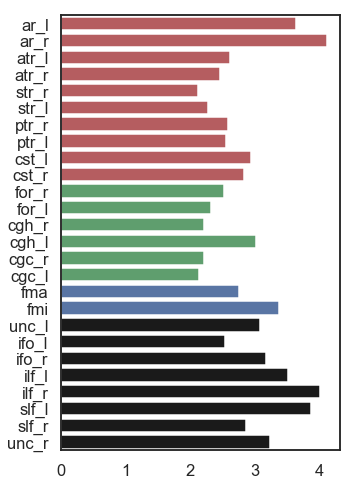

In [86]:
#fm = ForwardModel(2)
#param_list = [0,1,2]

#for name in ['csf_vol']:
#    Y,b,s = prepare(df,name)
#    samples,_ = do_fit(Y,b,s,fm)    
    
#grot=samples.mean(axis=0)

def quick_plot_bars(x):
    p = 0
    l = 1
    c = 2
    a = 3
    tracts_type = np.asarray([p,p,p,p,l,l,l,l,p,p,c,c,l,l,a,a,a,a,p,p,a,a,p,p,a,a])
    idx         = np.argsort(tracts_type)
    tracts_names_sorted = [tracts_names[idx[i]] for i in range(num_tracts)]

    fig, ax = plt.subplots(1,1,figsize=(5,8))

    sns.set_context('talk')
    sns.barplot(x=x,y=tracts_names_sorted,hue=tracts_type[idx],palette=['r','g','b','k'],dodge=False)
    plt.figure(figsize=(5,8))
    sns.set_context('talk')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:0], labels[:0])

    
quick_plot_bars(mean[0,:])    
#sns.scatterplot(x=beta1,y=beta2_prem)
#sns.scatterplot(x=beta1,y=beta2_term,color='r')
#[plt.text(x=T1[i],y=T2[i],s=tracts_names[i],fontsize=16) for i in range(len(tracts_names))]
#plt.xlabel('beta1')
#plt.ylabel('beta2')
#


## Model entropy

- Get entropy data
- Run model=2 using PCA dim reduction trick
- Save all betas into a cifti file
- View in workbench :)

In [74]:
# Loading data
dirname = '/Users/saad/Desktop/tmp_matteo'
df = pd.read_csv(os.path.join(dirname,'input_vars','input_vars_design_mat.csv'))

tmp = np.load(os.path.join(dirname,'input_vars','entropy.npz'))
en  = tmp['arr_0']


In [75]:
# Fitting the model
fm    = ForwardModel(2)
Y,b,s = prepare(df,Y=en.T,deconfound=False,normalise=True)
betas = do_pca_fit(Y,b,s,fm,keep=10)


In [76]:
import cifti, nibabel

left_mask  = nibabel.load(os.path.join(dirname,'input_vars','week40.L.atlasroi.10k.shape.gii')).darrays[0].data
right_mask = nibabel.load(os.path.join(dirname,'input_vars','week40.R.atlasroi.10k.shape.gii')).darrays[0].data

bm = cifti.BrainModel.from_mask(left_mask, name='CortexLeft') + cifti.BrainModel.from_mask(right_mask, name='CortexRight')

sc = cifti.Scalar.from_names(['beta1', 'beta2-term','beta2-prem','onset'])   
cifti.write(os.path.join(dirname,'entropy_model2_coefs.dscalar.nii'), betas, (sc, bm))


## Model cortical morphology



In [ ]:
# Loading data
dirname = '/Users/saad/Desktop/tmp_matteo'
df = pd.read_csv(os.path.join(dirname,'input_vars','input_vars_design_mat.csv'))

var = 'corr_thickness'
tmp = np.load(os.path.join(dirname,'input_vars',var+'.npz'))['arr_0']

# Fitting the model
fm    = ForwardModel(2)
Y,b,s = prepare(df,Y=tmp.T,deconfound=False,normalise=False)
betas = do_pca_fit(Y,b,s,fm,keep=10)

left_mask  = nibabel.load(os.path.join(dirname,'input_vars','week40.L.atlasroi.32k.inv.func.gii')).darrays[0].data
right_mask = nibabel.load(os.path.join(dirname,'input_vars','week40.R.atlasroi.32k.inv.func.gii')).darrays[0].data

bm = cifti.BrainModel.from_mask(left_mask, name='CortexLeft') + cifti.BrainModel.from_mask(right_mask, name='CortexRight')

sc = cifti.Scalar.from_names(['beta1', 'beta2-term','beta2-prem','onset'])   
cifti.write(os.path.join(dirname,var+'_model2_coefs.dscalar.nii'), betas, (sc, bm))


## Model blueprints
- Load blueprints
- For each tract 
    - Run model and save betas

In [130]:
dirname = '/Users/saad/Desktop/tmp_matteo'
df = pd.read_csv(os.path.join(dirname,'input_vars','input_vars_design_mat.csv'))

var = 'blueprints'
bp  = np.load(os.path.join(dirname,'input_vars',var+'.npz'))['arr_0']
bp  = bp[:,indluce_mask,:]

In [ ]:
# Save all mean BPs
sc = cifti.Scalar.from_names(tracts_names)   
cifti.write(os.path.join(dirname,'BluePrints.dscalar.nii'), np.log(bp.mean(axis=2).T), (sc, bm))


In [136]:
# Model tract area
thresh = 50
tracts_areas = np.sum(bp>thresh,axis=0)

# Loop through the tracts 
model = 2
fm    = ForwardModel(model)
results_tracts_area = np.zeros((1000,4,num_tracts))
for i in range(num_tracts):
    print(i)
    data,birth,scan = prepare(df,Y=tracts_areas[i,:].T,normalise=True)
    samples, ML = do_fit(data,birth,scan,fm)
    results_tracts_area[:,:,i] = samples


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


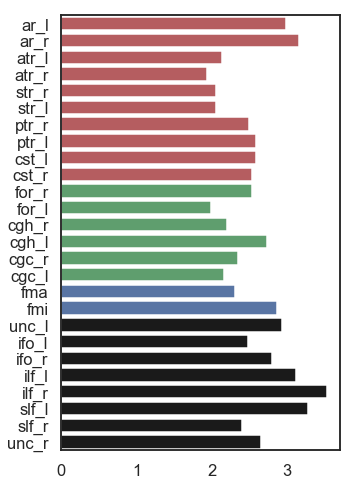

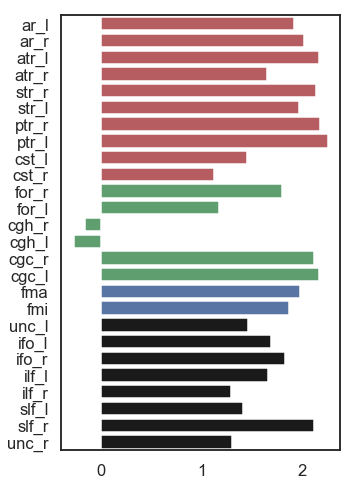

In [141]:
quick_plot_bars(res_tract_vol.mean(axis=0)[2,:])
quick_plot_bars(results_tracts_area.mean(axis=0)[2,:])


In [131]:
tracts_areas = np.sum(bp>thresh,axis=0)
tracts_areas_perc = np.mean(bp>thresh,axis=0)*100


In [ ]:
beta1      = []
beta2_term = []
beta2_prem = []
for i in range(len(results)):
    beta1.append(results[i][:,0].mean())
    beta2_term.append(results[i][:,1].mean())
    beta2_prem.append(results[i][:,2].mean())
    
beta1      = np.asarray(beta1)
beta2_term = np.asarray(beta2_term)
beta2_prem = np.asarray(beta2_prem)


In [ ]:
plt.figure(figsize=(5,8))
sns.set_context('talk')
sns.barplot(x=beta2_prem,y=tracts_names)
plt.figure(figsize=(5,8))
sns.set_context('talk')

sns.scatterplot(x=beta1,y=beta2_prem)
sns.scatterplot(x=beta1,y=beta2_term,color='r')
#[plt.text(x=T1[i],y=T2[i],s=tracts_names[i],fontsize=16) for i in range(len(tracts_names))]
plt.xlabel('beta1')
plt.ylabel('beta2')
plt.legend(['prem','term'])
